In [ ]:
# ======================================
# 📊 CANTEEN RECOMMENDER - EDA + MODEL + EVALUATION
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


In [ ]:
import pandas as pd


df = pd.read_csv(r"C:\Users\HP\Downloads\Canteen Recommendation System\ML\Data\raw\mock_canteen_orders.csv", parse_dates=["timestamp"])

df.head()


,order_id,user_id,item_id,item_name,category,quantity,total_price,timestamp
0,1,U186,D05,Idli,Breakfast,1,50,2025-10-23 06:12:00
1,2,U163,D03,Tea,Beverage,1,15,2025-10-29 18:34:00
2,3,U099,D10,Shake,Beverage,1,70,2025-10-19 17:55:00
3,4,U179,D03,Tea,Beverage,1,15,2025-10-25 06:13:00
4,5,U135,D02,Paneer Roll,Lunch,1,120,2025-10-12 06:10:00


In [ ]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_id     1200 non-null   int64         
 1   user_id      1200 non-null   object        
 2   item_id      1200 non-null   object        
 3   item_name    1200 non-null   object        
 4   category     1200 non-null   object        
 5   quantity     1200 non-null   int64         
 6   total_price  1200 non-null   int64         
 7   timestamp    1200 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 75.1+ KB


order_id       0
user_id        0
item_id        0
item_name      0
category       0
quantity       0
total_price    0
timestamp      0
dtype: int64

In [ ]:
popular = (
    df["item_name"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "dish_name", "item_name": "order_count"})
)
popular.head(10)


,order_count,count
0,Tea,249
1,Paneer Roll,192
2,Veg Thali,146
3,Samosa,115
4,Burger,104
5,Coffee,94
6,Poha,93
7,Idli,91
8,Shake,58
9,Paratha,58


In [ ]:
# ======================================
# LOAD DATA
# ======================================

df = pd.read_csv(r"C:\Users\HP\Downloads\Canteen Recommendation System\ML\Data\processed\orders_clean.csv")

print("📁 Dataset Shape:", df.shape)
print("\n🧾 Columns:", df.columns.tolist())
print("\n🔍 Missing Values:\n", df.isnull().sum())

df.head()


📁 Dataset Shape: (1200, 8)

🧾 Columns: ['order_id', 'user_id', 'item_id', 'item_name', 'category', 'quantity', 'total_price', 'timestamp']

🔍 Missing Values:
 order_id       0
user_id        0
item_id        0
item_name      0
category       0
quantity       0
total_price    0
timestamp      0
dtype: int64


,order_id,user_id,item_id,item_name,category,quantity,total_price,timestamp
0,1,U186,D05,Idli,Breakfast,1,50,2025-10-23 06:12:00
1,2,U163,D03,Tea,Beverage,1,15,2025-10-29 18:34:00
2,3,U099,D10,Shake,Beverage,1,70,2025-10-19 17:55:00
3,4,U179,D03,Tea,Beverage,1,15,2025-10-25 06:13:00
4,5,U135,D02,Paneer Roll,Lunch,1,120,2025-10-12 06:10:00


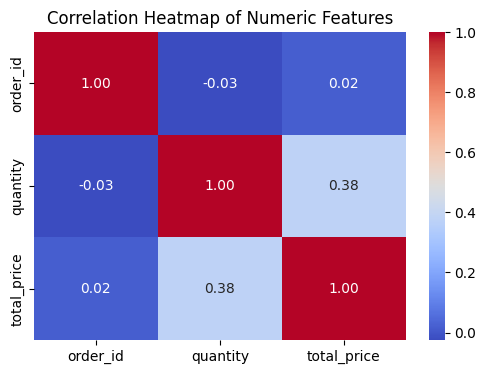

In [ ]:
# ======================================
# STEP 2️⃣ : EXPLORATORY DATA ANALYSIS (EDA)
# ======================================

df['timestamp'] = pd.to_datetime(df['timestamp'])

numeric_df = df.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [ ]:
# Descriptive statistics
numeric_df.describe()


,order_id,quantity,total_price
count,1200.000000,1200.000000,1200.000000
mean,600.500000,1.065000,58.404167
std,346.554469,0.290135,44.164177
min,1.000000,1.000000,15.000000
25%,300.750000,1.000000,20.000000
50%,600.500000,1.000000,50.000000
75%,900.250000,1.000000,90.000000
max,1200.000000,3.000000,360.000000


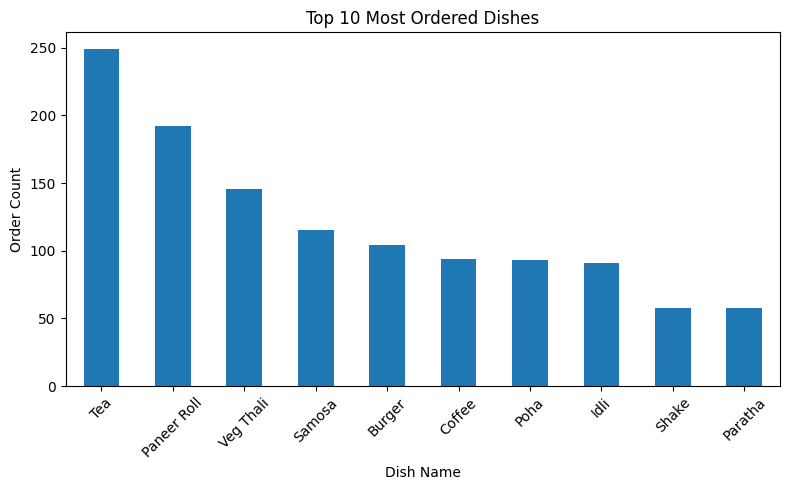

In [ ]:
plt.figure(figsize=(8,5))
df['item_name'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Most Ordered Dishes")
plt.xlabel("Dish Name")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ======================================
# STEP 3️⃣ : POPULARITY-BASED RECOMMENDER MODEL
# ======================================

df = df.sort_values("timestamp")

split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

N = 5
top_items = train_df["item_name"].value_counts().head(N).index.tolist()

print(f"\n🔥 Top {N} Most Popular Dishes:\n", top_items)



🔥 Top 5 Most Popular Dishes:
 ['Tea', 'Paneer Roll', 'Veg Thali', 'Burger', 'Samosa']


In [ ]:
# ======================================
# STEP 4️⃣ : MODEL EVALUATION (HIT RATE ACCURACY)
# ======================================

hits = test_df[test_df["item_name"].isin(top_items)]
hit_rate = len(hits) / len(test_df)

print(f"\n🎯 Model Accuracy (Hit Rate): {hit_rate:.2%}")
print(f"Train Orders: {len(train_df)} | Test Orders: {len(test_df)}")



🎯 Model Accuracy (Hit Rate): 62.08%
Train Orders: 960 | Test Orders: 240


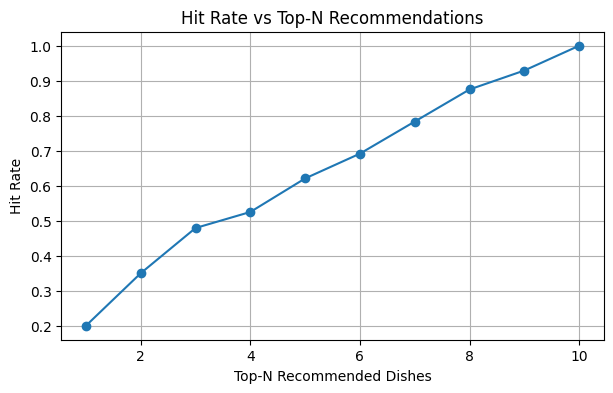

In [ ]:
plt.figure(figsize=(7, 4))

hit_rates = []
for N in range(1, 11):
    top_items_N = train_df["item_name"].value_counts().head(N).index.tolist()
    hits_N = test_df[test_df["item_name"].isin(top_items_N)]
    hit_rates.append(len(hits_N) / len(test_df))

plt.plot(range(1, 11), hit_rates, marker='o')
plt.title("Hit Rate vs Top-N Recommendations")
plt.xlabel("Top-N Recommended Dishes")
plt.ylabel("Hit Rate")
plt.grid(True)
plt.show()


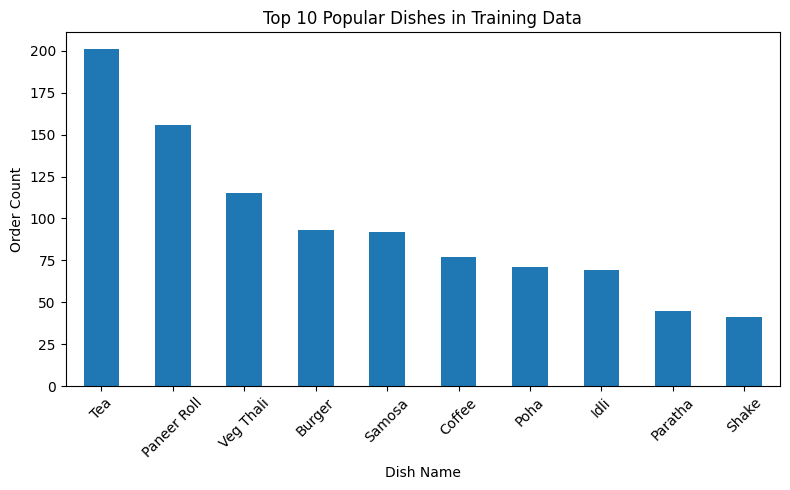

In [ ]:
plt.figure(figsize=(8,5))
train_df['item_name'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Popular Dishes in Training Data")
plt.xlabel("Dish Name")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:


def get_meal_period(hour):
    """Categorizes the hour into a specific meal period."""
    if 6 <= hour < 11:
        # 6 AM to 11 AM
        return "Breakfast"
    elif 11 <= hour < 16:
        # 11 AM to 4 PM (Peak Lunch Hours)
        return "Lunch"
    else:
        # 4 PM onwards (Dinner/Evening Snacks)
        return "Dinner"
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['meal_period'] = df['hour'].apply(get_meal_period)
print("✅ Meal period column created.")

time_based_popularity = df.groupby(['meal_period', 'item_name'])['quantity'].sum().reset_index()

time_based_popularity.rename(columns={'quantity': 'total_quantity_sold'}, inplace=True)

time_based_popularity['rank'] = (
    time_based_popularity.groupby('meal_period')['total_quantity_sold']
    .rank(method='dense', ascending=False)
)
top_n_by_time = time_based_popularity[time_based_popularity['rank'] <= 3].sort_values(
    ['meal_period', 'rank']
)
print("\n--- Top 3 Dishes by Meal Period (Contextual Popularity) ---")
print(top_n_by_time)

✅ Meal period column created.

--- Top 3 Dishes by Meal Period (Contextual Popularity) ---
   meal_period    item_name  total_quantity_sold  rank
8    Breakfast          Tea                   81   1.0
3    Breakfast  Paneer Roll                   64   2.0
9    Breakfast    Veg Thali                   51   3.0
18      Dinner          Tea                   93   1.0
13      Dinner  Paneer Roll                   82   2.0
19      Dinner    Veg Thali                   66   3.0
28       Lunch          Tea                   84   1.0
23       Lunch  Paneer Roll                   59   2.0
20       Lunch       Burger                   43   3.0


In [ ]:
from datetime import datetime, timedelta

# Popular in the last 7 days
recent = df[df["timestamp"] > (df["timestamp"].max() - timedelta(days=7))]
recent_popular = recent["item_name"].value_counts().head(5)
print("Trending This Week:\n", recent_popular)

# Popular by meal period
def get_meal_period(hour):
    if 6 <= hour < 11:
        return "Breakfast"
    elif 11 <= hour < 16:
        return "Lunch"
    else:
        return "Dinner"

df["meal_period"] = df["timestamp"].dt.hour.apply(get_meal_period)
meal_popular = (
    df.groupby("meal_period")["item_name"]
    .value_counts()
    .groupby(level=0)
    .head(3)
)
print(meal_popular)


Trending This Week:
 item_name
Tea            52
Paneer Roll    37
Veg Thali      33
Samosa         23
Poha           22
Name: count, dtype: int64
meal_period  item_name  
Breakfast    Tea            78
             Paneer Roll    60
             Veg Thali      46
Dinner       Tea            89
             Paneer Roll    80
             Veg Thali      64
Lunch        Tea            82
             Paneer Roll    52
             Burger         41
Name: count, dtype: int64


In [ ]:
def get_recommendations(df, mode="popular", top_n=5):
    if mode == "popular":
        data = (
            df.groupby("item_name")["quantity"]
              .sum()
              .reset_index()
              .sort_values(by="quantity", ascending=False)
        )
    elif mode == "trending":
        recent_period = df["timestamp"].max() - pd.Timedelta(days=7)
        data = (
            df[df["timestamp"] >= recent_period]
              .groupby("item_name")["quantity"]
              .sum()
              .reset_index()
              .sort_values(by="quantity", ascending=False)
        )
    else:
        raise ValueError("Mode must be 'popular' or 'trending'")
    return data.head(top_n)["item_name"].tolist()

# Try both modes
print("Top popular dishes:", get_recommendations(df, "popular", 5))
print("Top trending dishes:", get_recommendations(df, "trending", 5))


Top popular dishes: ['Tea', 'Paneer Roll', 'Veg Thali', 'Samosa', 'Burger']
Top trending dishes: ['Tea', 'Paneer Roll', 'Veg Thali', 'Poha', 'Samosa']


In [ ]:
top5 = popular.head(5)
top5.to_json(r"C:\Users\HP\Downloads\Canteen Recommendation System\ML\Data\top_dishes.json", orient="records", indent=2)
print("✅ top_dishes.json saved!")


✅ top_dishes.json saved!
